# Completing mid-ocean ridge faults detection using semi-supervised learning

![](content/image_faults.jpg)

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from skimage.morphology import binary_dilation
from utils import dataSplit
from model import unet, mean_iou
from ipywidgets import interact, widgets

## Given dataset

In [2]:
bat = scipy.io.loadmat("Bathy.mat")['IMG2']
fault = scipy.io.loadmat("Fault_Bool.mat")['Fault_Bool']
fault = binary_dilation(fault, selem=np.ones((10,10)))

In [3]:
bat_mean = np.nanmean(bat)
bat_std = np.nanstd(bat)
    
x, y = dataSplit(bat, 256), dataSplit(fault, 256) 
x_all, y_all = np.copy(x), np.copy(y)

idx = list(map(lambda x: not np.all(x), np.isnan(x).sum(axis=(1,2,3)) > (256**2) / 2))
x, y = x[idx], y[idx]

fail_threshold = 0.05
y_mean = y.mean(axis=(1, 2, 3))
x, y = x[y_mean>fail_threshold], y[y_mean>fail_threshold]

x_mean = np.nanmean(x, axis=(1, 2))[:, None, None, :]
x_std = np.nanstd(x, axis=(1, 2))[:, None, None, :]
x = (x - x_mean)/x_std
x[np.isnan(x)] = 0

x_all_mean = np.nanmean(x_all, axis=(1, 2))[:, None, None, :]
x_all_std = np.nanstd(x_all, axis=(1, 2))[:, None, None, :]
x_all = (x_all - x_all_mean)/x_all_std
x_all[np.isnan(x_all)] = 0

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [4]:
@interact(index=widgets.IntSlider(min=0, max=len(x), step=1, value=2))
def display(index):
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
    cm1 = ax1.pcolormesh(np.squeeze(x[index]), vmin=-2, vmax=2)
    fig.colorbar(cm1, ax=ax1)
    ax1.set_title("Sea levels")

    cm2 = ax2.pcolormesh(np.squeeze(y[index]), vmin=0, vmax=1)
    fig.colorbar(cm2, ax=ax2)
    ax2.set_title("Labeled fails")

    ax3.hist(bat.ravel())
    ax3.set_title("Sea levels distribution")

    plt.show()

interactive(children=(IntSlider(value=2, description='index', max=43), Output()), _dom_classes=('widget-intera…

## Training the model

![](content/u-net-architecture.png)

In [5]:
input_shape = (256, 256, 1)

model = unet(input_shape=input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.fit(x, y, epochs=30, batch_size=4, validation_split=0.2, verbose=0)
y_pred = model.predict(x_all)

## Evaluating predictions

In [6]:
y_pred_all = np.squeeze(y_pred.reshape((8, 15, 256, 256, 1)))

y_pred_all = np.block([[y_pred_all[i, j] for i in range(8)] for j in range(15)])

In [7]:
y_all = np.squeeze(y_all.reshape((8, 15, 256, 256, 1)))

y_all = np.block([[y_all[i, j] for i in range(8)] for j in range(15)])

In [8]:
x_all = np.squeeze(x_all.reshape((8, 15, 256, 256, 1)))

x_all = np.block([[x_all[i, j] for i in range(8)] for j in range(15)])

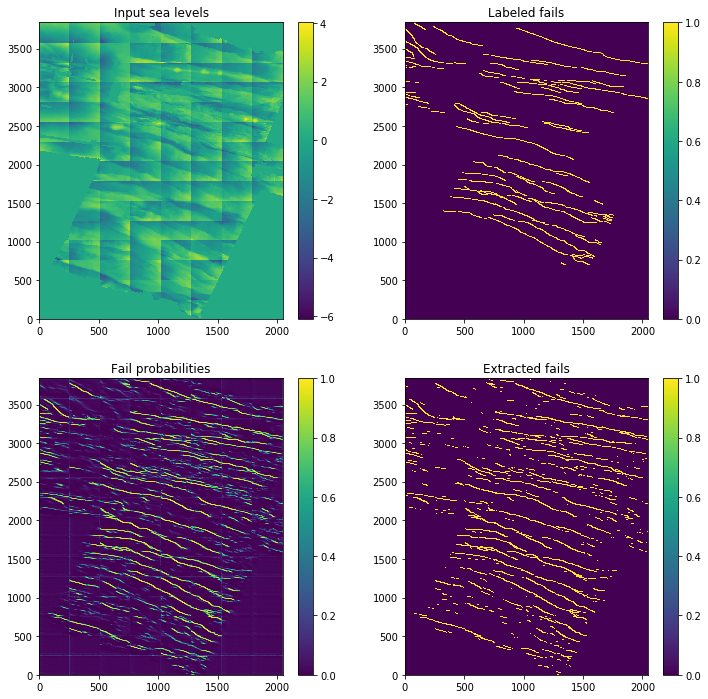

In [9]:
fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

cm0 = ax0.pcolormesh(np.squeeze(x_all))
fig.colorbar(cm0, ax=ax0)
ax0.set_title("Input sea levels")

cm1 = ax1.pcolormesh(np.squeeze(y_all), vmin=0, vmax=1)
fig.colorbar(cm1, ax=ax1)
ax1.set_title("Labeled fails")

cm2 = ax2.pcolormesh(np.squeeze(y_pred_all), vmin=0, vmax=1)
fig.colorbar(cm2, ax=ax2)
ax2.set_title("Fail probabilities")

cm3 = ax3.pcolormesh(np.squeeze(y_pred_all >0.5), vmin=0, vmax=1)
fig.colorbar(cm3, ax=ax3)
ax3.set_title("Extracted fails")

plt.show()